# DELOS Aqua Technical Test

## Question 1
>How can you generate a random number between 1 – 7 with only 1 dice?

### Reasoning
We can follow this simple algorithm step by step:
1. Generate a random number [1,6] (inclusively) 7 times.
2. Find the highest number.
4. If multiple indexes have the same highest value, regenerate random numbers for those indexes only, and repeat step 2.
5. Otherwise, return the index with the highest number.

For example:
1. We got the following random numbers for the first random number generation: ```[2,2,4,4,1,5,3]```
2. The highest number is `4` and with indexes 2 and 3.
3. Regenerate random numbers for indexes 2 and 3: ```[2,2,5,6,1,5,3]```.
4. Found new highest number `6` and no overlap, return index 3.

Following this approach will only take `O(n)` at best for both time & space complexities which is efficient for the system to run. It also does not require any mathematical formulas or complex algorithms to solve this problem.

### Tools
We only need the `random` package from Python itself to utilize `randint` function to generate a random number.

In [56]:
import random

mini, maxi = 1, 6 # 6-sided dice
max_roll = 7 # random number between 1-7 inclusively

# initially generates random numbers 7 times and find the highest number
result = [random.randint(mini, maxi) for _ in range(max_roll)]
highest = max(result)
# if multiple indexes have the same highest value and regenerate random numbers for those indexes only
while len(set(result)) != max_roll:
    count = 0
    same = []
    # find overlapping indexes
    for i, num in enumerate(result):
        if highest == num:
            count += 1
            same.append(i)
    # break if overlapping indexes are not found
    if count == 1:
        break
    # regenerate random numbers for overlapping indexes with the same number
    else:
        for i in range(len(same)):
            result[same[i]] = random.randint(mini, maxi)
        highest = max(result)

for i in range(len(result)):
    if result[i] == highest:
        print("Random number:", i+1)
        break


Random number: 7


## Question 2

### Dataset
From the get go, we could see that this dataset is poorly maintained. First thing that I realized is that the parameters: TAN ppm, Phosphate ppm, and Phytoplankton cells/ml are examined in an odd way. They are being examined every 2 or 3 days apart without any descriptions or explanations whatsoever. This can hinder our work because we need to contact experts who are working for a fish/shrimp farm. We are not sure whether these null values are indeed nulls or not. Next, the row values have empty/null values: '' and '-'. It would be better if we can reach an agreement to have one value for empty data. This will make data cleaning and versioning process easier and more efficient.

### Data Cleaning
The data cleaning process is rather simple with following steps:
1. Rename columns for easier readability
2. Remove unused columns & rows with any null values (we are only using this dataset to examine them and not to build an ML model, hence removing null values is not going to cost us anything)
3. Cast each column into its respective appropriate data types (this is very important later when we want to version the data so that it can track data type changes).

### Tools
1. Plotting & visualization tools: `seaborn` and `matplotlib`
2. Data manipulation tools: `pandas`
3. Statistical analysis tools: `scipy`

### Analysis
We can use Pearson's Correlation to identify correlation between inputs and parameters. From the analysis below, we can say that:
- Temperatures (morning, afternoon, evening) generally have negative correlations against the parameters (TAN, Phosphate, and Phytoplankton). In other words, a pond will have a decreased TAN, Phosphate, and Phytoplankton values when the temperature is high. It seems like it does make sense according to this [publication](https://pubs.acs.org/doi/pdf/10.1021/ja01651a096)
- The number of kg feeds per day have strong positive correlations, especially on Phosphate and Phytoplankton. This is another way of saying "if we feed a fish tank/pond with more food, the healthy the ecosystem becomes". This is because both compounds act as primary producers in the food chain. Phytoplanktons can be seen as the "trees" in the water where they synthesize their own foods.
- The correlation between the parameters itself also have strong correlations. As it is mentioned before, these parameters indicate how healthy the ecosystem of a pond is. Higher TAN value leads to a higher number of Phosphate and Phytoplankton and vice versa.

In [292]:
import pandas as pd
from scipy import stats

import seaborn as sns
import matplotlib.pyplot as plt

data = pd.read_csv('data.csv')
data.head()

,Days of production,Pond Identifier,Temperature in the Morning,Temperature n the Afternoon,Temperature in the Evening,Feed per day (kg of shrimp feed),TAN ppm,Phosphate ppm,Phytoplankton cells/ml,Unnamed: 9,...,Unnamed: 14,Unnamed: 15,Unnamed: 16,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23
0,1.0,A1,29.0,30,29,3.5,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2.0,A1,30.0,32,29,3.5,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3.0,A1,29.0,33,31,4,0.606,0.036,"3,000",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4.0,A1,29.0,32,31,4,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5.0,A1,30.0,30,28,4.5,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [347]:
def clean_data(df):
    # rename columns
    rename_cols = {'Days of production': 'days_production', 'Pond Identifier': 'pond_id', 'Temperature in the Morning': 'morning_temp', 
                    'Temperature n the Afternoon': 'afternoon_temp', 'Temperature in the Evening': 'evening_temp', 'Feed per day (kg of shrimp feed)': 'feed_per_day',
                    'TAN ppm': 'tan', 'Phosphate ppm': 'phosphate', 'Phytoplankton cells/ml': 'phytoplankton'}
    df = df.rename(columns=rename_cols)
    # drop columns with prefix "Unnamed"
    df = df.loc[:,~df.columns.str.match("Unnamed")]
    # drop null and '-' values
    df = df.dropna()
    for cols in df.columns:
        if '-' in df[cols].values:
            df = df[df[cols]!='-']
    # cast to appropriate dtypes
    df['days_production'] = df['days_production'].astype('int')
    df['morning_temp'] = df['morning_temp'].astype('float')
    df['afternoon_temp'] = df['afternoon_temp'].astype('float')
    df['evening_temp'] = df['evening_temp'].astype('float')
    df['feed_per_day'] = df['feed_per_day'].astype('float')
    df['phytoplankton'] = df['phytoplankton'].str.replace(',', '')
    df['phytoplankton'] = df['phytoplankton'].astype('float')

    return df
    
def run_analysis(df):

    def _correlation(x, y):
        print(f'Analyzing correlation between {x} and {y}...')
        grid = sns.JointGrid(x=x, y=y, data=df)
        slope, intercept, r, p, std_err = stats.linregress(df[x], df[y])
        model = _linear_reg(df[x], slope, intercept)
        grid.plot_joint(sns.scatterplot, color="g")
        plt.plot(df[x], model, linewidth=5, linestyle=':')
        sns.histplot(df[x], ax=grid.ax_marg_x).set(title=f'{x}-{y} Correlation Plot')
        print('R score:', r)

    def _linear_reg(x, slope, intercept):
        return slope*x + intercept

    null_flag = False
    for c in df.columns:
        if sum(df[c].isnull()) > 0:
            null_flag = True
            print(f'Number of empty rows for column {c}: {sum(df[c].isnull())}')
    if not null_flag:
        print('No null values found!')

    _correlation('morning_temp', 'tan')
    _correlation('afternoon_temp', 'tan')
    _correlation('evening_temp', 'tan')

    _correlation('morning_temp', 'phosphate')
    _correlation('afternoon_temp', 'phosphate')
    _correlation('evening_temp', 'phosphate')

    _correlation('morning_temp', 'phytoplankton')
    _correlation('afternoon_temp', 'phytoplankton')
    _correlation('evening_temp', 'phytoplankton')    

    _correlation('feed_per_day', 'tan')
    _correlation('feed_per_day', 'phosphate')
    _correlation('feed_per_day', 'phytoplankton')

    _correlation('tan', 'phosphate')
    _correlation('tan', 'phytoplankton')
    _correlation('phosphate', 'phytoplankton')
    

<ipython-input-347-93d74c8b0eb3>:12: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if '-' in df[cols].values:


No null values found!
Analyzing correlation between morning_temp and tan...
R score: -0.29945429655241135
Analyzing correlation between afternoon_temp and tan...
R score: -0.3117706625286538
Analyzing correlation between evening_temp and tan...
R score: -0.32167177664673635
Analyzing correlation between morning_temp and phosphate...
R score: -0.21244051586990975
Analyzing correlation between afternoon_temp and phosphate...
R score: -0.15954214924169005
Analyzing correlation between evening_temp and phosphate...
R score: -0.16535163818536813
Analyzing correlation between morning_temp and phytoplankton...
R score: -0.22792360892191252
Analyzing correlation between afternoon_temp and phytoplankton...
R score: -0.20022204536615537
Analyzing correlation between evening_temp and phytoplankton...
R score: -0.21241152006398917
Analyzing correlation between feed_per_day and tan...
R score: 0.1664229999982753
Analyzing correlation between feed_per_day and phosphate...
R score: 0.577642817585434


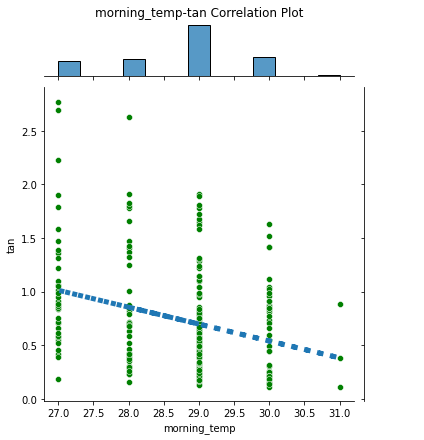

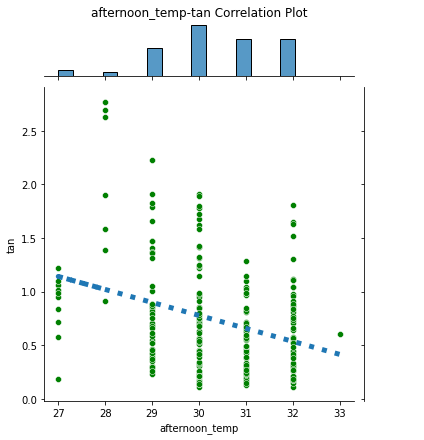

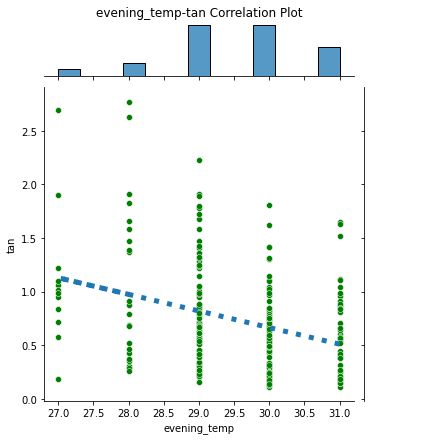

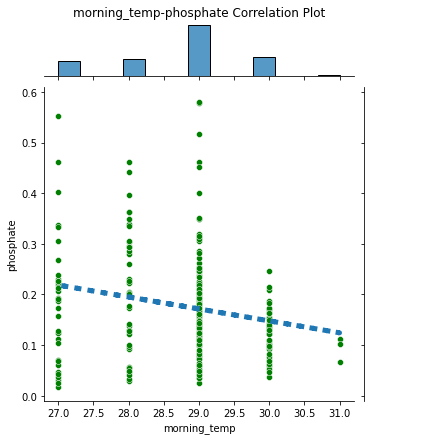

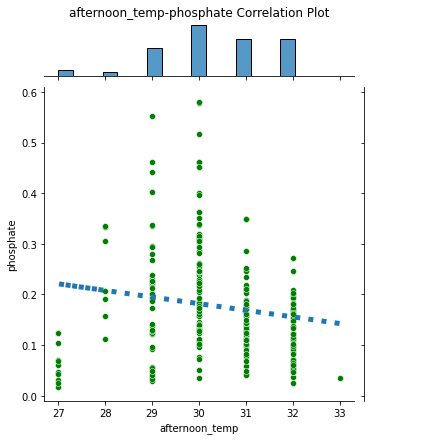

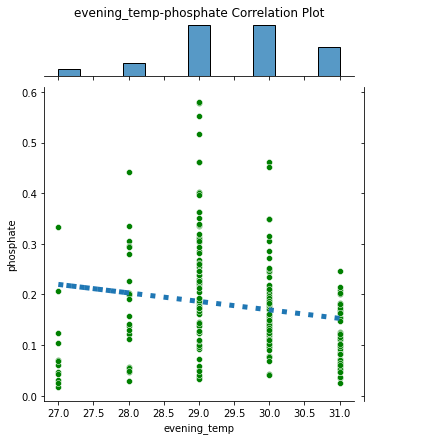

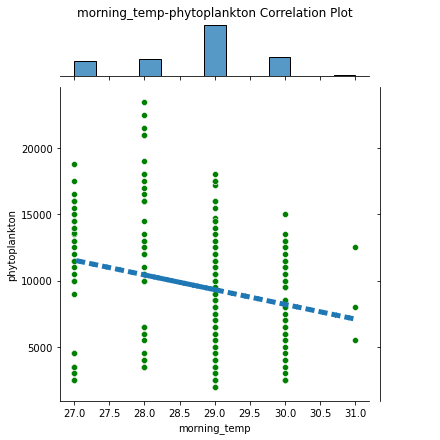

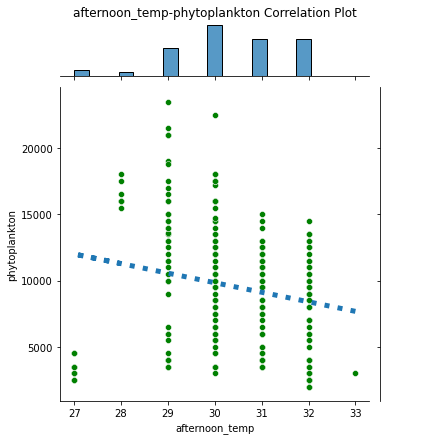

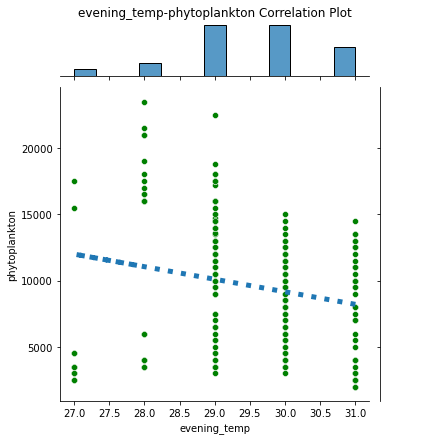

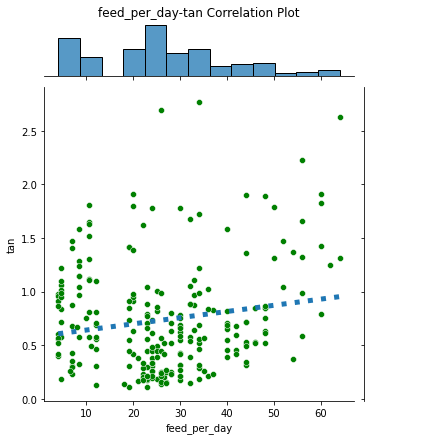

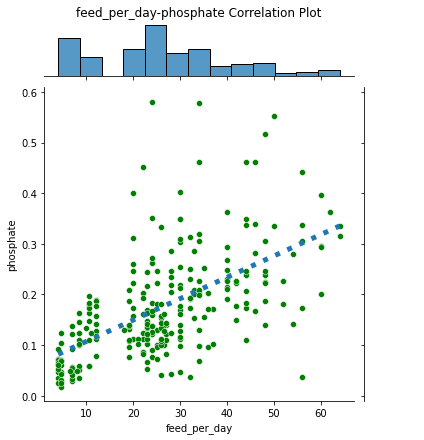

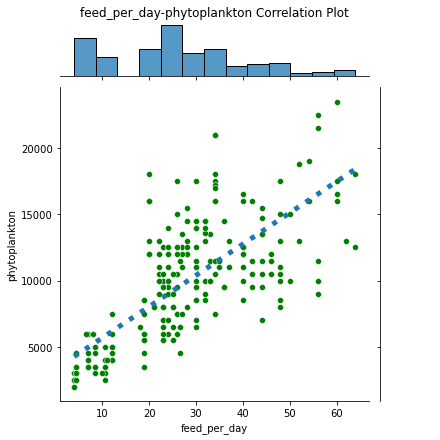

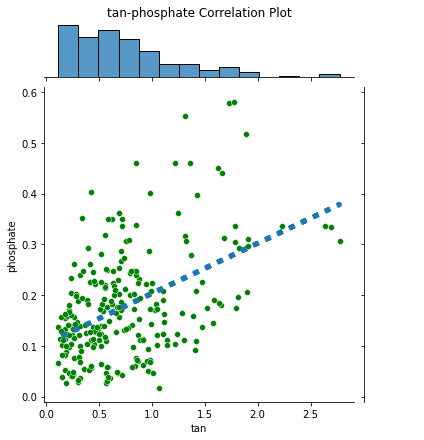

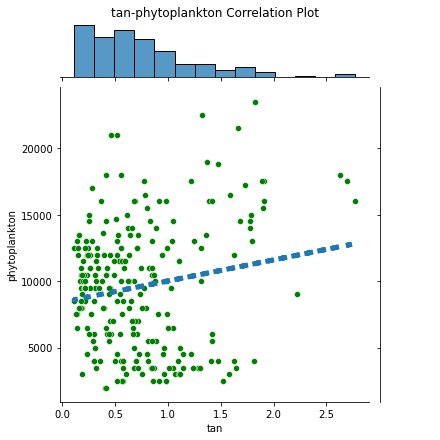

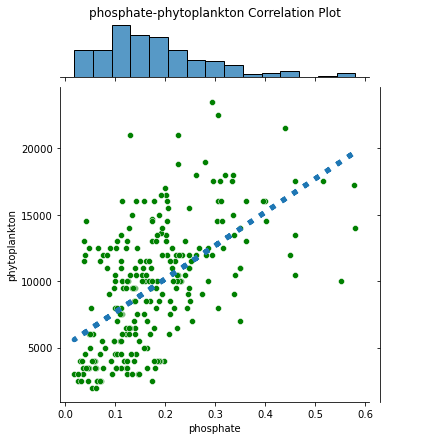

: 

In [348]:
cleaned_df = clean_data(data)
run_analysis(cleaned_df)

## Question 3

>Q: With more time and more control over the data points collected, what would you
change? and what additional analysis or processes would you undertake to
understand the factors driving changes in TAN and Phosphate? Please refer to big data and
ML techniques.

1. Cluster analysis: we could build a simple unsupervised clustering model to cluster different ponds according to their respective inputs and parameter values.
2. Factor analysis: a.k.a dimensional reduction, we can use this to discover independent variables.
3. Time series analysis: since we saw "Days of production" column in the data, we could think this is as a time series problem.
4. Decision tree: we could review the inputs and parameters into greater details by building a decision tree model and discover which threshold values for each of them will lead to a healthier pond.